# Multivariate time series forecasting

In [32]:
from utilities.std_imports import *
from utilities.tf_imports import *

from utils import *

import tensorflow.keras.optimizers as tko

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Load data

In [33]:
data = pd.read_csv(csv_path + 'time_series/AAPL1216.csv')[::-1]
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
1005,2012-01-03,409.399998,412.499989,408.999989,411.230000,75555200,53.278774
1004,2012-01-04,410.000011,414.680012,409.279995,413.440010,65005500,53.565102
1003,2012-01-05,414.950005,418.550007,412.670006,418.029995,67817400,54.159778
1002,2012-01-06,419.770008,422.749996,419.220009,422.400002,79573200,54.725955
1001,2012-01-09,425.499992,427.750004,421.349991,421.730000,98506100,54.639149


### Data preparation

In [34]:
ope = data.iloc[:,1].tolist()
hig = data.iloc[:,2].tolist()
low = data.iloc[:,3].tolist()
clo = data.iloc[:,6].tolist()
vol = data.iloc[:,5].tolist()

In [35]:
mw = 30
step = 1
fh = 1
emb_size = 5

X, Y = [], []
for i in range(0, len(data)-mw-1, step): 
    ope_mw = ope[i:i+mw]
    hig_mw = hig[i:i+mw]
    low_mw = low[i:i+mw]
    clo_mw = clo[i:i+mw]
    vol_mw = vol[i:i+mw]

    ope_mw = (np.array(ope_mw) - np.mean(ope_mw)) / np.std(ope_mw)
    hig_mw = (np.array(hig_mw) - np.mean(hig_mw)) / np.std(hig_mw)
    low_mw = (np.array(low_mw) - np.mean(low_mw)) / np.std(low_mw)
    clo_mw = (np.array(clo_mw) - np.mean(clo_mw)) / np.std(clo_mw)
    vol_mw = (np.array(vol_mw) - np.mean(vol_mw)) / np.std(vol_mw)
    
    x_i = clo[i:i+mw]
    y_i = clo[i+mw+fh]  

    last_close = x_i[-1]
    next_close = y_i

    if last_close < next_close:
        y_i = [1, 0]
    else:
        y_i = [0, 1] 

    x_i = np.column_stack((ope_mw, hig_mw, low_mw, clo_mw, vol_mw))

    X.append(x_i)
    Y.append(y_i)

In [35]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], emb_size))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], emb_size))

### Build model

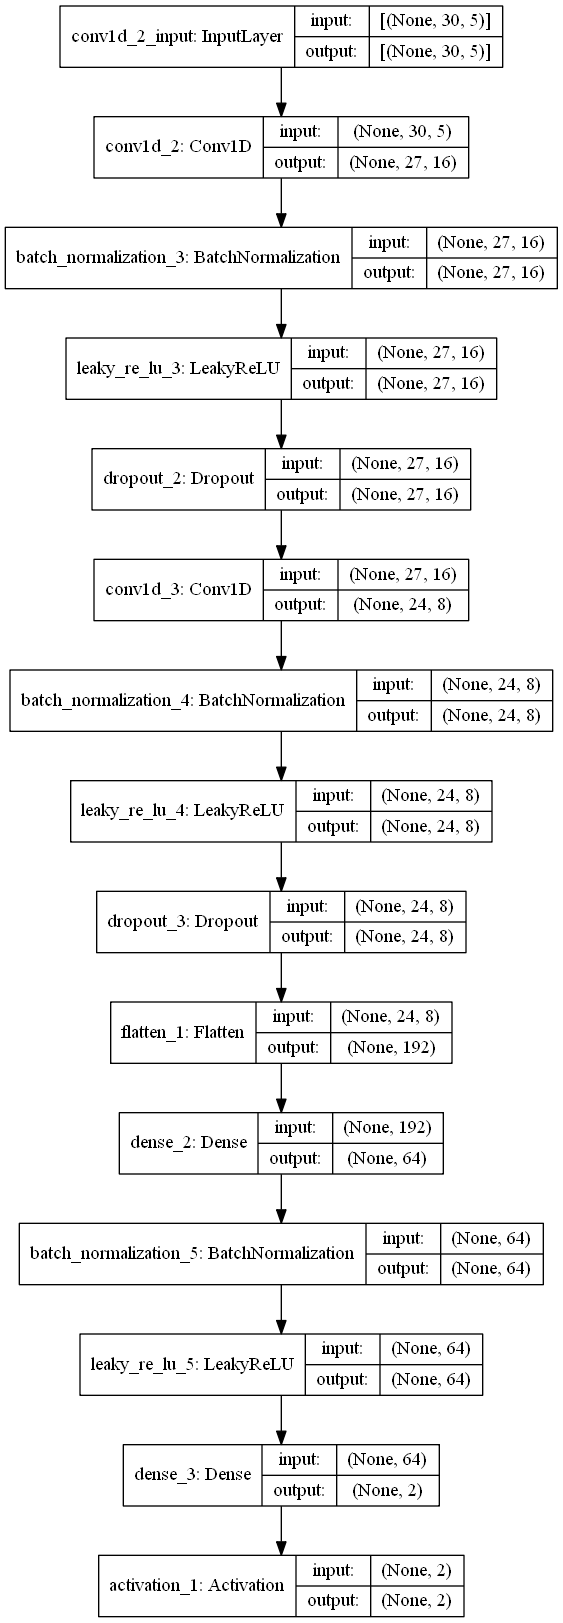

In [36]:
model = tkm.Sequential()
model.add(tkl.Convolution1D(filters=16, kernel_size=4, input_shape = (mw, emb_size)))
model.add(tkl.BatchNormalization())
model.add(tkl.LeakyReLU())
model.add(tkl.Dropout(0.5))

model.add(tkl.Convolution1D(filters=8, kernel_size=4))
model.add(tkl.BatchNormalization())
model.add(tkl.LeakyReLU())
model.add(tkl.Dropout(0.5))

model.add(tkl.Flatten())

model.add(tkl.Dense(64))
model.add(tkl.BatchNormalization())
model.add(tkl.LeakyReLU())


model.add(tkl.Dense(2))
model.add(tkl.Activation('softmax'))

opt = tko.Nadam(lr=0.002)

reduce_lr = tkc.ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = tkc.ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
tku.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training 

In [37]:
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 128, verbose=1, validation_data=(X_test, Y_test), callbacks=[reduce_lr, checkpointer], shuffle=True)

Epoch 1/100
6/6 [==============================] - 2s 46ms/step - loss: 0.9134 - accuracy: 0.5124 - val_loss: 0.7212 - val_accuracy: 0.5369

Epoch 00001: val_loss improved from inf to 0.72125, saving model to lolkek.hdf5
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.8356 - accuracy: 0.5008 - val_loss: 0.7329 - val_accuracy: 0.5082

Epoch 00002: val_loss did not improve from 0.72125
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7883 - accuracy: 0.5015 - val_loss: 0.7209 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.72125 to 0.72088, saving model to lolkek.hdf5
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.7283 - accuracy: 0.5349 - val_loss: 0.7177 - val_accuracy: 0.5041

Epoch 00004: val_loss improved from 0.72088 to 0.71768, saving model to lolkek.hdf5
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6926 - accuracy: 0.5468 - val_loss: 0.7112 - val_accuracy: 0.52

### Validation

In [38]:
model.load_weights("lolkek.hdf5")
pred = model.predict(np.array(X_test))

conf_mat = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])
conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=1)
pd.DataFrame(conf_mat)

,0,1
0,0.676471,0.407407
1,0.397059,0.500000


In [39]:
for i in range(len(pred)):
    print(Y_test[i], pred[i])

[1 0] [0.4074469  0.59255314]
[1 0] [0.34480885 0.6551912 ]
[0 1] [0.5707801  0.42921984]
[1 0] [0.41694802 0.583052  ]
[0 1] [0.6655798  0.33442023]
[1 0] [0.5236358  0.47636425]
[1 0] [0.4097073  0.59029275]
[1 0] [0.5683837 0.4316163]
[0 1] [0.54091716 0.45908284]
[0 1] [0.6700608  0.32993913]
[0 1] [0.5327196  0.46728045]
[0 1] [0.5421429 0.4578571]
[1 0] [0.5841085 0.4158915]
[1 0] [0.7273658  0.27263424]
[0 1] [0.5949813  0.40501872]
[0 1] [0.6338326  0.36616743]
[1 0] [0.24683131 0.75316864]
[0 1] [0.62364495 0.37635508]
[0 1] [0.3673174  0.63268256]
[1 0] [0.5876637  0.41233626]
[0 1] [0.6741453  0.32585475]
[1 0] [0.6732062 0.3267938]
[0 1] [0.3695486 0.6304514]
[0 1] [0.39071998 0.60928   ]
[0 1] [0.48388016 0.51611984]
[1 0] [0.67811245 0.32188752]
[1 0] [0.53866726 0.46133274]
[1 0] [0.55252534 0.4474747 ]
[1 0] [0.50185394 0.49814603]
[1 0] [0.6878257  0.31217426]
[1 0] [0.6475502  0.35244972]
[1 0] [0.7302759  0.26972407]
[1 0] [0.5559395  0.44406053]
[1 0] [0.74961007 0.

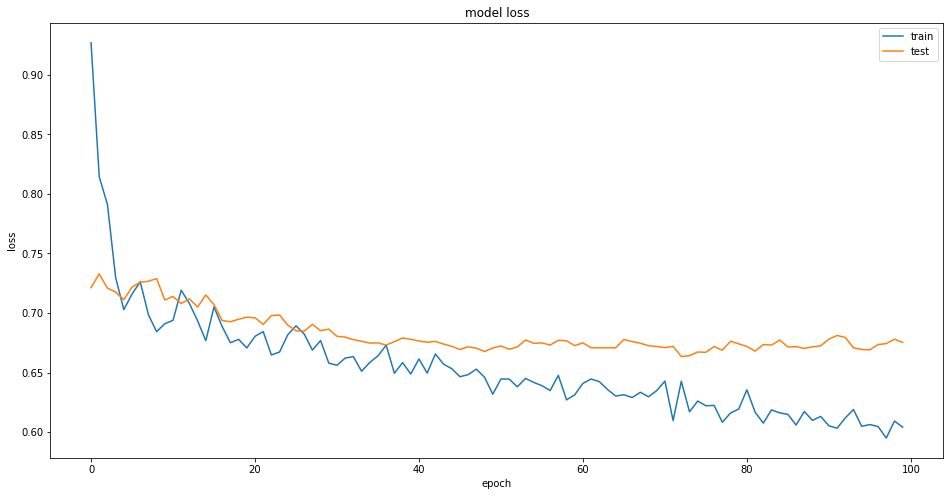

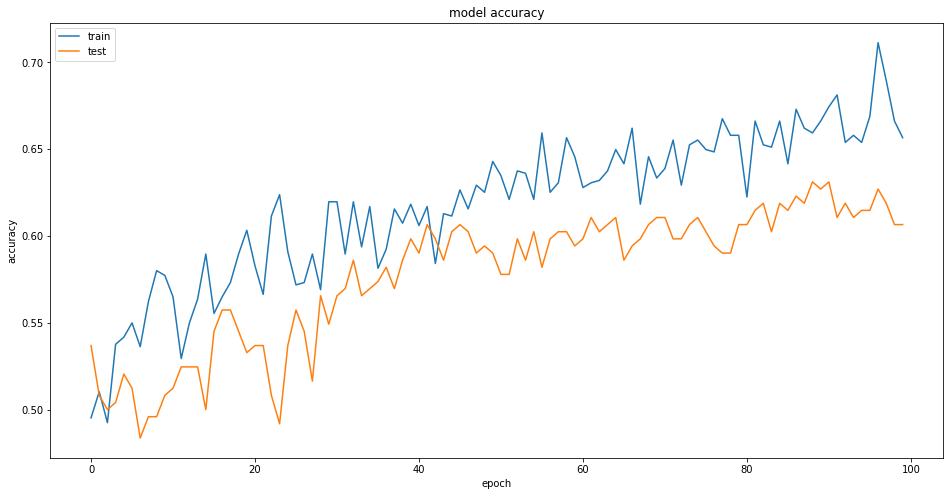

In [40]:
plt.figure(figsize=[16,8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure(figsize=[16,8])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Updated to Python3.8 and TF2 from:

https://alexrachnog.medium.com/neural-networks-for-algorithmic-trading-2-1-multivariate-time-series-ab016ce70f57